<a href="https://colab.research.google.com/github/harnalashok/CatEncodersFamily/blob/main/diabetes_pca_xgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catencfamily

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.6/228.6 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 86.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 25.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.1/174.1 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 34.9 MB/s eta 0:00:00
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395106 sha256=ec83d9fa1dcb725433a44610a81ce355109da3e0a9efc0ca07309fd9f0e01334
  Stored in directory: /root/.cache/pip/wheels/b5/42/97/11eee99f5c1e4fdfc170f0a54f9c9eb195df6

In [2]:
# 1.0 Call libraries
import pandas as pd
import numpy as np


# 1.01
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# 1.02
import matplotlib.pyplot as plt
import seaborn as sns


# 1.03
import xgboost as xgb


# 1.04
from catencfamily.encoders import CatEncodersFamily
from catencfamily import utils

Note: to be able to use all crisp methods, you need to install some additional packages:  {'wurlitzer', 'graph_tool', 'karateclub', 'infomap', 'leidenalg'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'infomap', 'wurlitzer', 'leidenalg'}


In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [4]:
# Read Data
data = pd.read_csv("https://raw.githubusercontent.com/harnalashok/CatEncodersFamily/main/datasets/diabetes.csv")

In [5]:
data.head(3)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [6]:
y = data.pop("Outcome")

In [7]:
# Check nulls
data.isnull().sum().sum()


0

In [8]:

# Discretise all features of data. And also split dataset.
# into train/test
orig_train, orig_test, train_binned, test_binned  = utils.generateSklearnData(data,
                                                                              y,
                                                                              bins = 30,
                                                                              test_size = 0.1,
                                                                              genColName = False  # Keep orig col names
                                                                              )

In [9]:
# Check  original data:

orig_train.head(3)
orig_test.head(3)
orig_train.shape

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,target
750,7.0,62.0,78.0,0.0,0.0,32.6,0.391,41.0,0
1,5.0,95.0,72.0,33.0,0.0,37.7,0.370,27.0,0
568,0.0,131.0,0.0,0.0,0.0,43.2,0.270,26.0,1


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,target
563,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,1
271,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,0
735,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,1


(692, 9)

In [10]:
# Check discretised features
# train/test in binned data and original 
# split data have the same row-indicies:

train_binned.head(3)
test_binned.head(3)
train_binned.shape

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,target
750,413,810,1220,161,201,2415,285,3210,0
1,49,815,1218,1610,201,2417,284,323,0
568,41,820,121,161,201,2420,283,323,1


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,target
563,411,823,1218,1611,201,2416,288,3215,1
271,42,813,1217,169,201,2412,284,325,0
735,415,828,1216,161,201,2411,288,326,1


(692, 9)

In [11]:
# Pop out targets
ytr = train_binned.pop('target')
yte = test_binned.pop("target")

In [13]:
## Developing models
# Which are our cat columns
# We will consider few columns
# Ref: https://www.kaggle.com/code/kanncaa1/feature-selection-and-data-visualization

cat_cols = list(train_binned.columns)
cat_cols
len(cat_cols)  # 8


# Keep interacting columns, same
# as cat columns:
interactingCatCols = cat_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

8

In [14]:
# Instantiate CustomTransformer class:
ct = CatEncodersFamily(
                       cMeasures=[1,1,1,1,None,1,1],
                       )

# Fit it:
ct.fit(train_binned, cat_cols, interactingCatCols) 


Record set no is 1  
Set of records is:  [('Pregnancies', 'Glucose', [1, 1, 1, 1, None, 1, 1]), ('Pregnancies', 'BloodPressure', [1, 1, 1, 1, None, 1, 1]), ('Pregnancies', 'SkinThickness', [1, 1, 1, 1, None, 1, 1]), ('Pregnancies', 'Insulin', [1, 1, 1, 1, None, 1, 1]), ('Pregnancies', 'BMI', [1, 1, 1, 1, None, 1, 1]), ('Pregnancies', 'DiabetesPedigreeFunction', [1, 1, 1, 1, None, 1, 1]), ('Pregnancies', 'Age', [1, 1, 1, 1, None, 1, 1]), ('Pregnancies', 'Pregnancies_p_BloodPressure', [1, 1, 1, 1, None, 1, 1]), ('Pregnancies', 'Pregnancies_p_Insulin', [1, 1, 1, 1, None, 1, 1]), ('Pregnancies', 'Insulin_p_Age', [1, 1, 1, 1, None, 1, 1]), ('Pregnancies', 'Pregnancies_p_SkinThickness', [1, 1, 1, 1, None, 1, 1]), ('Pregnancies', 'BloodPressure_p_Insulin', [1, 1, 1, 1, None, 1, 1]), ('Pregnancies', 'Pregnancies_p_DiabetesPedigreeFunction', [1, 1, 1, 1, None, 1, 1]), ('Pregnancies', 'Pregnancies_p_Glucose', [1, 1, 1, 1, None, 1, 1]), ('Pregnancies', 'Pregnancies_p_Age', [1, 1, 1, 1, None, 1, 1

CatEncodersFamily(cMeasures=[1, 1, 1, 1, None, 1, 1],
                  pathToStoreProgress=PosixPath('/content/allmodels/progress'))

In [15]:
# Transform test_binned data:
test_trans = ct.transform(test_binned)
test_trans.shape



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  1400
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 0.721856 MB
Mem usage after dtype transformation is: 0.366784 MB


(76, 1176)

In [16]:
train_trans= ct.transform(train_binned)
train_trans.shape



====Reading all model-dicts from RAM


====All saved model-dicts read! Model files are intact!
====Total model-dict are:  1400
====Sending model loading progress to file: /content/allmodels/progress/load_stored_models.txt
When loading is in progress, open this file with notepad++ AND NOT with notepad


Current mem usage is: 6.487616 MB
Mem usage after dtype transformation is: 3.254592 MB


(692, 1176)

In [17]:
train_trans.head()
test_trans.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,deg_Pregnancies_ck_Glucose,eig_Pregnancies_ck_Glucose,...,eig_Age_ck_Glucose_p_DiabetesPedigreeFunction,pr_Age_ck_Glucose_p_DiabetesPedigreeFunction,clu_Age_ck_Glucose_p_DiabetesPedigreeFunction,bet_Age_ck_Glucose_p_DiabetesPedigreeFunction,eig_Age_ck_Glucose_p_Age,deg_Age_ck_Glucose_p_BloodPressure,eig_Age_ck_Glucose_p_BloodPressure,pr_Age_ck_Glucose_p_BloodPressure,clu_Age_ck_Glucose_p_BloodPressure,bet_Age_ck_Glucose_p_BloodPressure
0,413,810,1220,161,201,2415,285,3210,1.0000,0.258097,...,0.242594,0.050664,0.731602,0.033925,0.253392,0.730769,0.219195,0.043759,0.760234,0.016868
1,49,815,1218,1610,201,2417,284,323,1.0000,0.258097,...,0.230215,0.045544,0.805263,0.011643,0.008042,0.846154,0.247009,0.049917,0.714286,0.026482
2,41,820,121,161,201,2420,283,323,1.0000,0.258097,...,0.230215,0.045544,0.805263,0.011643,0.008042,0.846154,0.247009,0.049917,0.714286,0.026482
3,44,817,1217,167,201,2412,283,322,0.9375,0.249324,...,0.242276,0.053311,0.656126,0.049578,0.161088,0.884615,0.246364,0.053481,0.640316,0.057763
4,46,818,1211,164,201,2411,281,321,1.0000,0.258097,...,0.254577,0.058521,0.613333,0.084800,0.141440,0.884615,0.246060,0.052851,0.644269,0.046565


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,deg_Pregnancies_ck_Glucose,eig_Pregnancies_ck_Glucose,...,eig_Age_ck_Glucose_p_DiabetesPedigreeFunction,pr_Age_ck_Glucose_p_DiabetesPedigreeFunction,clu_Age_ck_Glucose_p_DiabetesPedigreeFunction,bet_Age_ck_Glucose_p_DiabetesPedigreeFunction,eig_Age_ck_Glucose_p_Age,deg_Age_ck_Glucose_p_BloodPressure,eig_Age_ck_Glucose_p_BloodPressure,pr_Age_ck_Glucose_p_BloodPressure,clu_Age_ck_Glucose_p_BloodPressure,bet_Age_ck_Glucose_p_BloodPressure
0,411,823,1218,1611,201,2416,288,3215,1.000,0.258097,...,0.193323,0.039619,0.757353,0.010484,-0.304009,0.576923,0.175784,0.036470,0.771429,0.016245
1,42,813,1217,169,201,2412,284,325,1.000,0.258097,...,0.250321,0.052080,0.711462,0.028903,0.059724,0.846154,0.244806,0.050060,0.701299,0.028720
2,415,828,1216,161,201,2411,288,326,0.875,0.237373,...,0.222121,0.043489,0.830409,0.011087,0.084014,0.807692,0.240894,0.047713,0.752381,0.019399
3,42,814,1217,167,204,2413,282,321,1.000,0.258097,...,0.254577,0.058521,0.613333,0.084800,0.141440,0.884615,0.246060,0.052851,0.644269,0.046565
4,41,821,1210,1611,206,2420,2829,326,1.000,0.258097,...,0.222121,0.043489,0.830409,0.011087,0.084014,0.807692,0.240894,0.047713,0.752381,0.019399


In [18]:
_= orig_train.pop('target')
_= orig_test.pop('target')

In [19]:
pca = PCA(n_components = 2,  whiten= True, random_state= None)
ss= StandardScaler()
dx = pca.fit_transform(ss.fit_transform(orig_train))
dx.shape

(692, 2)

In [20]:
da = train_trans.iloc[:,8:]
da.isnull().sum().sum()  # If ot null perform imputation with SimpleImputer(strategy = 'median')

0

In [21]:
pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
da = pca.fit_transform(ss.fit_transform(da))
da.shape

(692, 2)

In [22]:
colnames = ["pc" + str(i) for i in range(dx.shape[1])]
dx = pd.DataFrame(dx, columns = colnames)
da = pd.DataFrame(da, columns = colnames)

<Axes: xlabel='pc0', ylabel='pc1'>

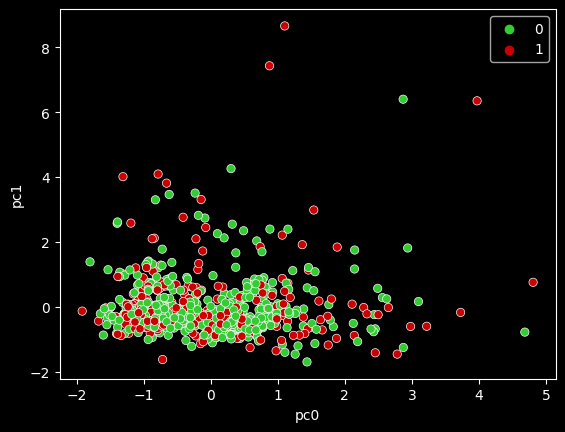

In [23]:
plt.style.use("dark_background")
sns.scatterplot(data = da, x= 'pc0', y = 'pc1', hue = ytr.values, palette = ["#33cc33", "#cc0000"])


<Axes: xlabel='pc0', ylabel='pc1'>

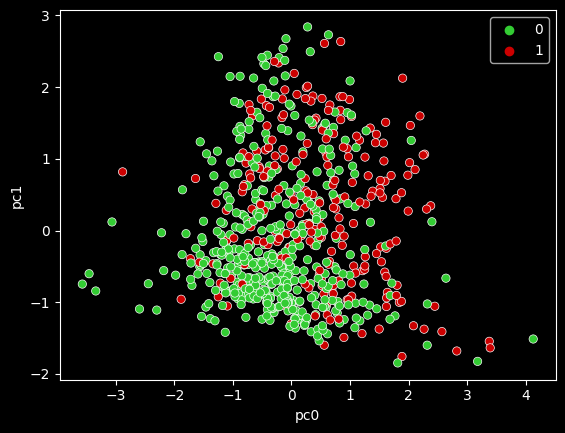

In [24]:
plt.style.use("dark_background")
sns.scatterplot(data = dx, x= 'pc0', y = 'pc1', hue = ytr.values, palette = ["#33cc33", "#cc0000"])

In [26]:

evals_result= {}
model_orig = xgb.XGBClassifier( n_estimators= 200,
                           verbosity = 3,
                           eta = 0.06,      # 0.06
                           max_depth = 6,
                           subsample = 0.8,           # 0.8
                           evals_result = evals_result,
                           random_state = 70,
                           )


tr_X =   orig_train # orig_train#
test_X = orig_test  # orig_test
ytr = ytr #y_train
yte = yte #y_test


model_orig.fit(tr_X, ytr.values,                   # Xtr, ytr
          early_stopping_rounds = 50,   # 10% of n_estimators
          eval_set=[ (test_X, yte.values)],
          eval_metric = ['auc']    # binary classification problem
          )



[17:13:56] WARNING: ../src/learner.cc:767: 
Parameters: { "evals_result" } are not used.

[17:13:56] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[17:13:56] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.70916
[17:13:56] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.73864
[17:13:56] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 58 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.74112
[17:13:56] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.75213
[17:13:56] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.75036
[17:13:56] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.74929

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              evals_result={}, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None, ...)

In [41]:

evals_result= {}
model_trans = xgb.XGBClassifier( n_estimators= 500,
                           verbosity = 3,
                           eta = 0.06,      # 0.06
                           max_depth = 6,
                           subsample = 0.8,           # 0.8
                           evals_result = evals_result,
                           random_state = 70,
                           )


tr_X =   train_trans[fe_1[:60]]
test_X = test_trans[fe_1[:60]]
ytr = ytr #y_train
yte = yte #y_test


model_trans.fit(tr_X, ytr.values,                   # Xtr, ytr
          early_stopping_rounds = 50,   # 10% of n_estimators
          eval_set=[ (test_X, yte.values)],
          eval_metric = ['auc']    # binary classification problem
          )



[17:19:51] WARNING: ../src/learner.cc:767: 
Parameters: { "evals_result" } are not used.

[17:19:51] DEBUG: ../src/gbm/gbtree.cc:157: Using tree method: 2
[17:19:52] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[0]	validation_0-auc:0.68004
[17:19:52] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[1]	validation_0-auc:0.72621
[17:19:52] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[2]	validation_0-auc:0.72017
[17:19:52] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=6
[3]	validation_0-auc:0.72550
[17:19:52] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 52 extra nodes, 0 pruned nodes, max_depth=6
[4]	validation_0-auc:0.72727
[17:19:52] INFO: ../src/tree/updater_prune.cc:98: tree pruning end, 68 extra nodes, 0 pruned nodes, max_depth=6
[5]	validation_0-auc:0.72869

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.06, eval_metric=None,
              evals_result={}, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None, ...)

In [33]:
fe_1,fe_0 = utils.xgImptFeatures(model_trans, tr_X.columns )

Order of feature importance is by 'gain'


In [36]:
fe_1

['eig_Glucose_ck_SkinThickness_p_BMI',
 'clu_Age_ck_BMI_p_DiabetesPedigreeFunction',
 'bet_Age_ck_SkinThickness_p_DiabetesPedigreeFunction',
 'eig_Glucose_ck_DiabetesPedigreeFunction_p_Age',
 'deg_Glucose_ck_SkinThickness_p_Insulin',
 'clu_Age_ck_BloodPressure_p_DiabetesPedigreeFunction',
 'pr_Glucose_ck_SkinThickness_p_BMI',
 'deg_DiabetesPedigreeFunction_ck_Glucose_p_BMI',
 'eig_Glucose_ck_BMI_p_Age',
 'deg_BloodPressure_ck_Pregnancies_p_DiabetesPedigreeFunction',
 'bet_Pregnancies_ck_BloodPressure_p_Age',
 'eig_Insulin_ck_BMI_p_DiabetesPedigreeFunction',
 'clu_BMI_ck_SkinThickness',
 'deg_BMI_ck_Glucose_p_DiabetesPedigreeFunction',
 'clu_BloodPressure_ck_Glucose_p_DiabetesPedigreeFunction',
 'deg_DiabetesPedigreeFunction_ck_BMI',
 'deg_Age_ck_Pregnancies_p_Glucose',
 'deg_Glucose_ck_DiabetesPedigreeFunction',
 'pr_Age_ck_Pregnancies_p_Insulin',
 'eig_Age_ck_BMI_p_DiabetesPedigreeFunction',
 'eig_BMI_ck_Pregnancies_p_BloodPressure',
 'pr_Glucose_ck_BloodPressure_p_BMI',
 'deg_Diabete